In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report


In [3]:
import sqlite3

In [4]:
conn = sqlite3.connect(r"D:\northwind_project\northwind-SQLite3-main\dist\northwind.db")

In [5]:
# Load tables
customers = pd.read_sql("SELECT * FROM Customers", conn)       
orders = pd.read_sql("SELECT * FROM Orders", conn)
order_details = pd.read_sql("SELECT * FROM [Order Details]", conn)
products = pd.read_sql("SELECT * FROM Products", conn)


In [6]:

# convert OrderDate to datetime
orders["OrderDate"] = pd.to_datetime(orders["OrderDate"], errors='coerce')

# Merge orders and order_details
sales = order_details.merge(orders, on="OrderID")

# Merge products for price info
sales = sales.merge(products, on="ProductID")


In [7]:
sales

,OrderID,ProductID,UnitPrice_x,Quantity,Discount,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,...,ShipCountry,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice_y,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248,11,14.00,12,0.0,VINET,5,2016-07-04,2016-08-01,2016-07-16,...,France,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
1,10248,42,9.80,10,0.0,VINET,5,2016-07-04,2016-08-01,2016-07-16,...,France,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
2,10248,72,34.80,5,0.0,VINET,5,2016-07-04,2016-08-01,2016-07-16,...,France,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0
3,10249,14,18.60,9,0.0,TOMSP,6,2016-07-05,2016-08-16,2016-07-10,...,Germany,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
4,10249,51,42.40,40,0.0,TOMSP,6,2016-07-05,2016-08-16,2016-07-10,...,Germany,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609278,26529,10,31.00,26,0.0,DUMON,6,NaT,2023-02-21 23:37:27,2023-01-10 09:47:23,...,UK,Ikura,4,8,12 - 200 ml jars,31.00,31,0,0,0
609279,26529,46,12.00,18,0.0,DUMON,6,NaT,2023-02-21 23:37:27,2023-01-10 09:47:23,...,UK,Spegesild,21,8,4 - 450 g glasses,12.00,95,0,0,0
609280,26529,26,31.23,3,0.0,DUMON,6,NaT,2023-02-21 23:37:27,2023-01-10 09:47:23,...,UK,Gumbär Gummibärchen,11,3,100 - 250 g bags,31.23,15,0,0,0
609281,26529,27,43.90,24,0.0,DUMON,6,NaT,2023-02-21 23:37:27,2023-01-10 09:47:23,...,UK,Schoggi Schokolade,11,3,100 - 100 g pieces,43.90,49,0,30,0


In [8]:
# Calculate Revenue per order line
sales["Revenue"] = sales["UnitPrice_x"] * sales["Quantity"] * (1 - sales["Discount"])

In [9]:
# Aggregate to customer-level
customer_df = (
    sales.groupby("CustomerID")
    .agg(
        TotalOrders=("OrderID","nunique"),
        TotalRevenue=("Revenue","sum"),
        AvgOrderValue=("Revenue","mean"),
        FirstOrderDate=("OrderDate","min"),
        LastOrderDate=("OrderDate","max")
    )
    .reset_index()
)

# Customer lifetime and average days between orders
customer_df["CustomerLifetimeDays"] = (customer_df["LastOrderDate"] - customer_df["FirstOrderDate"]).dt.days
customer_df["AvgDaysBetweenOrders"] = customer_df["CustomerLifetimeDays"] / customer_df["TotalOrders"]

# Merge customer info (CompanyName, Country)
customer_df = customer_df.merge(
    customers[["CustomerID","CompanyName","Country"]],
    on="CustomerID",
    how="left"
)

# Fill missing values
customer_df.fillna({
    "TotalOrders":0,
    "TotalRevenue":0,
    "AvgOrderValue":0,
    "CustomerLifetimeDays":0,
    "AvgDaysBetweenOrders":0,
    "CompanyName":"Unknown",
    "Country":"Unknown"
}, inplace=True)

# Preview
customer_df.head()

,CustomerID,TotalOrders,TotalRevenue,AvgOrderValue,FirstOrderDate,LastOrderDate,CustomerLifetimeDays,AvgDaysBetweenOrders,CompanyName,Country
0,ALFKI,163,3.965465e+06,744.688254,2017-08-25,2018-04-09,227.0,1.392638,Alfreds Futterkiste,Germany
1,ANATR,195,5.534357e+06,738.209504,2016-09-18,2018-03-04,532.0,2.728205,Ana Trujillo Emparedados y helados,Mexico
2,ANTON,163,4.311774e+06,725.033469,2016-11-27,2018-01-28,427.0,2.619632,Antonio Moreno Taquería,Mexico
3,AROUT,156,4.251822e+06,718.820223,2016-11-15,2018-04-10,511.0,3.275641,Around the Horn,UK
4,BERGS,178,4.833399e+06,740.183542,2016-08-12,2018-03-04,569.0,3.196629,Berglunds snabbköp,Sweden


## EDA 

In [10]:
customer_df.isnull().sum()

CustomerID              0
TotalOrders             0
TotalRevenue            0
AvgOrderValue           0
FirstOrderDate          4
LastOrderDate           4
CustomerLifetimeDays    0
AvgDaysBetweenOrders    0
CompanyName             0
Country                 0
dtype: int64

In [11]:
# Earliest order in the dataset
earliest_order = orders["OrderDate"].min()
latest_order = orders["OrderDate"].max()

# Fill nulls
customer_df["FirstOrderDate"] = customer_df["FirstOrderDate"].fillna(earliest_order)
customer_df["LastOrderDate"] = customer_df["LastOrderDate"].fillna(latest_order)

<Axes: xlabel='TotalRevenue'>

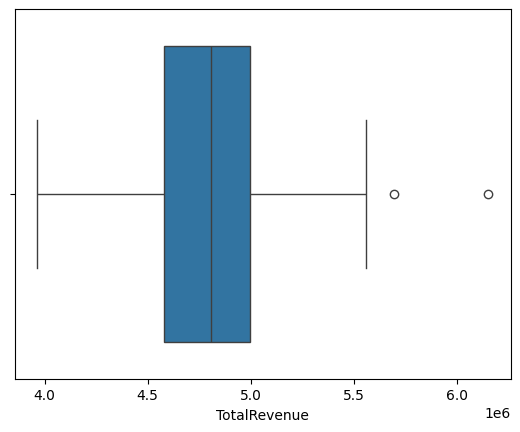

In [12]:
sns.boxplot(x=customer_df["TotalRevenue"])


In [13]:
# Find a threshold, e.g., 95th percentile
threshold = customer_df["TotalRevenue"].quantile(0.95)
customer_df = customer_df[customer_df["TotalRevenue"] <= threshold]


<Axes: xlabel='TotalRevenue'>

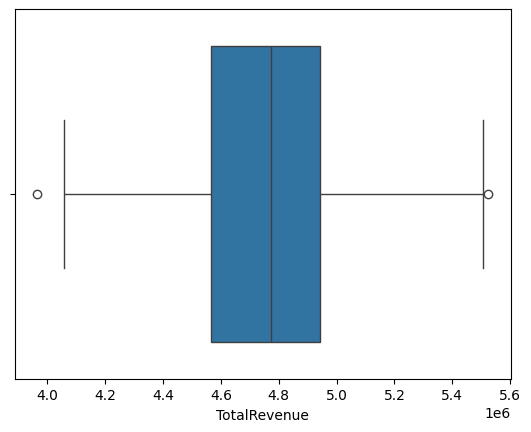

In [14]:
sns.boxplot(x=customer_df["TotalRevenue"])


In [16]:
num_features = ["TotalOrders","TotalRevenue","AvgOrderValue","CustomerLifetimeDays","AvgDaysBetweenOrders"]
customer_df[num_features].describe()

,TotalOrders,TotalRevenue,AvgOrderValue,CustomerLifetimeDays,AvgDaysBetweenOrders
count,88.000000,8.800000e+01,88.000000,88.000000,88.000000
mean,173.670455,4.771463e+06,735.753647,470.125000,2.698574
std,11.510836,3.560130e+05,9.057015,182.374555,1.040549
min,154.000000,3.965465e+06,713.628280,0.000000,0.000000
25%,164.750000,4.566279e+06,729.976810,376.000000,2.174020
50%,174.500000,4.773391e+06,735.408448,528.000000,3.009097
75%,182.000000,4.942446e+06,742.365856,602.250000,3.397017
max,203.000000,5.524517e+06,755.250601,663.000000,3.876543


In [17]:
scaler = MinMaxScaler()
customer_df[num_features] = scaler.fit_transform(customer_df[num_features])

In [18]:
# Order frequency
customer_df["OrderFrequency"] = customer_df["TotalOrders"] / (customer_df["CustomerLifetimeDays"] + 1)

# Revenue per day
customer_df["RevenuePerDay"] = customer_df["TotalRevenue"] / (customer_df["CustomerLifetimeDays"] + 1)

# Extract month & weekday from LastOrderDate
customer_df["LastOrderMonth"] = customer_df["LastOrderDate"].dt.month
customer_df["LastOrderWeekday"] = customer_df["LastOrderDate"].dt.day_name()


In [19]:
# Region from Country
def country_region(country):
    if country in ["USA","Canada"]:
        return "North America"
    elif country in ["UK","Germany","France"]:
        return "Europe"
    else:
        return "Other"

customer_df["Region"] = customer_df["Country"].apply(country_region)

# OneHot encode Region
customer_df = pd.get_dummies(customer_df, columns=["Region"], drop_first=True)


In [20]:
latest_date = orders["OrderDate"].max()
customer_df["MonthsInactive"] = ((latest_date - customer_df["LastOrderDate"]).dt.days)/30
customer_df["Churned"] = (customer_df["MonthsInactive"] > 6).astype(int)  # 6-month inactivity rule


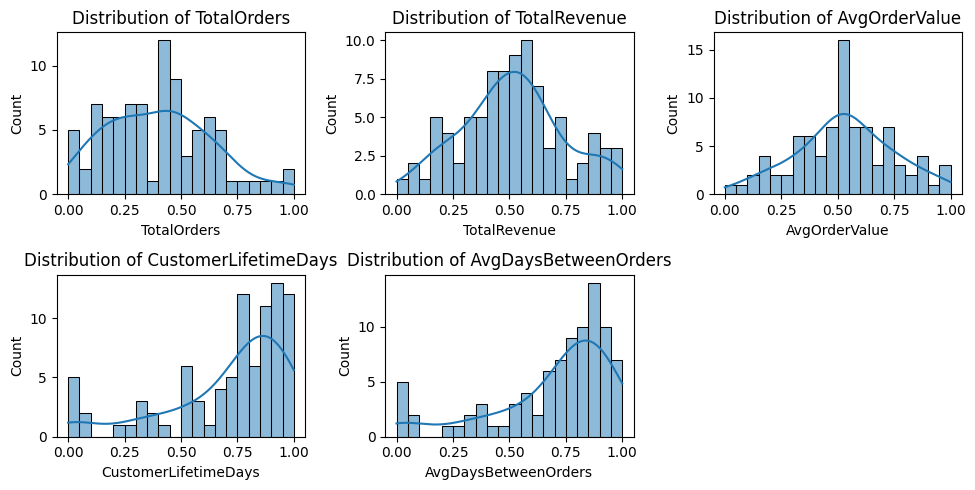

In [34]:
# List of features to plot
features = ["TotalOrders","TotalRevenue","AvgOrderValue","CustomerLifetimeDays","AvgDaysBetweenOrders"]

plt.figure(figsize=(10,5))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(customer_df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

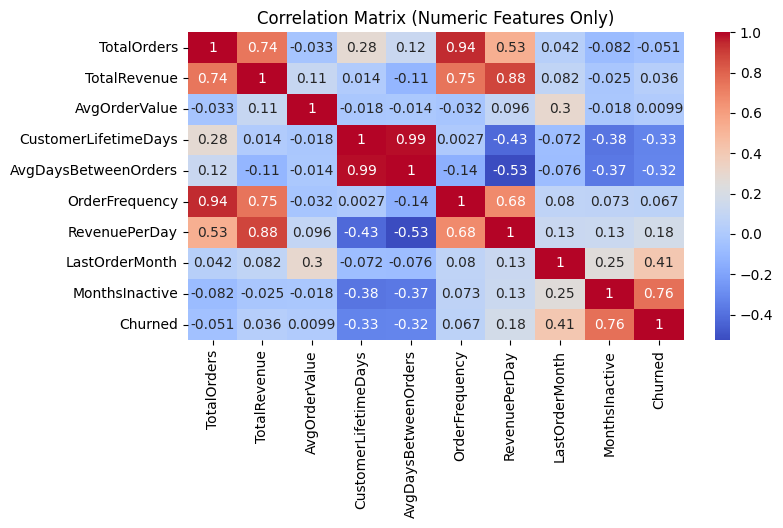

In [29]:
numeric_df = customer_df.select_dtypes(include=np.number)
plt.figure(figsize=(8,4))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()

In [22]:
# Features to keep
features = [
    "MonthsInactive",      # Strongest correlation with Churned
    "LastOrderMonth",      # Moderate correlation
    "RevenuePerDay",       # Informative
    "OrderFrequency"       # Informative
]

X = customer_df[features]
y = customer_df["Churned"]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [24]:
lr_model = LogisticRegression(max_iter=1000)

# Train
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]

Accuracy: 0.9444444444444444


c:\Users\ssc\miniconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Precision: 0.0
Recall: 0.0
ROC-AUC: 1.0


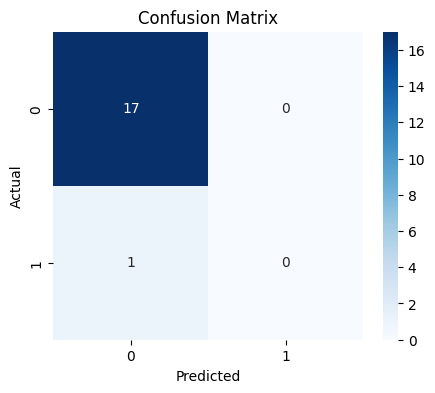

In [25]:

# Accuracy, precision, recall
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_prob))



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [26]:
# Example: X = features, y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Using class_weight to handle imbalance
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[17  0]
 [ 0  1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         1

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



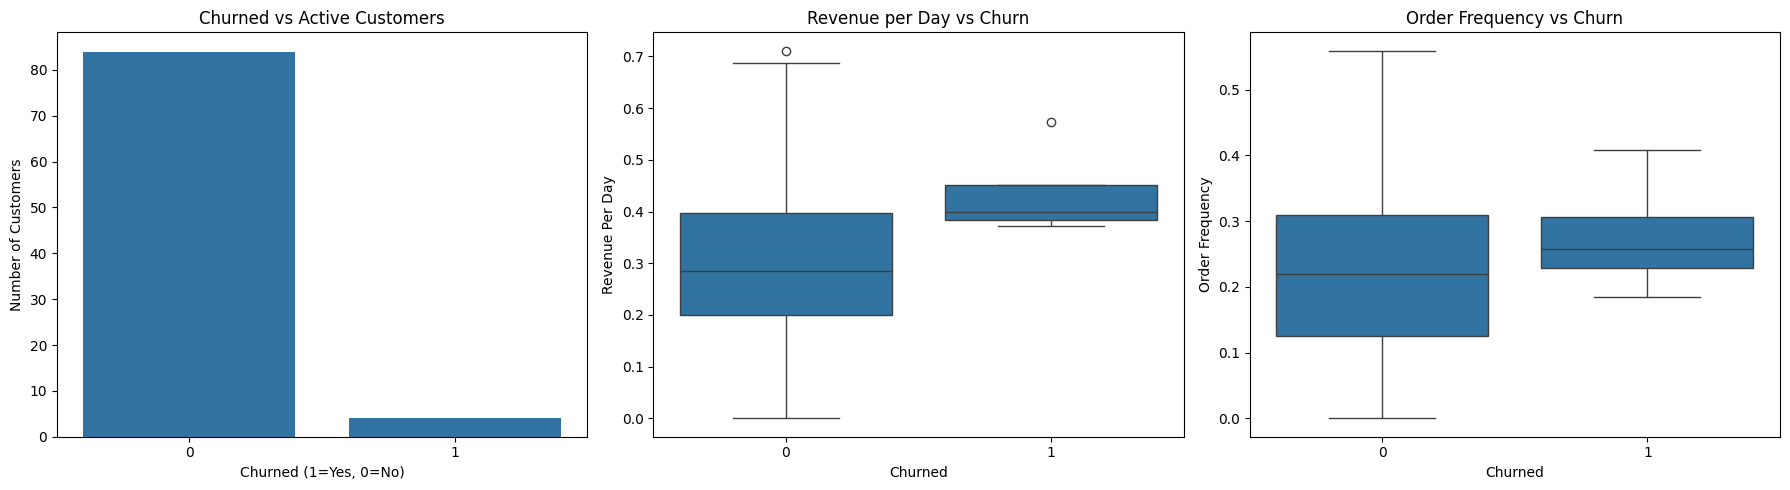

In [27]:
# Churn distribution
plt.figure(figsize=(18,5))

# Plot 1: Churned vs Active Customers
plt.subplot(1, 3, 1)
sns.countplot(x="Churned", data=customer_df)
plt.title("Churned vs Active Customers")
plt.xlabel("Churned (1=Yes, 0=No)")
plt.ylabel("Number of Customers")

# Plot 2: Revenue per Day vs Churn
plt.subplot(1, 3, 2)
sns.boxplot(x="Churned", y="RevenuePerDay", data=customer_df)
plt.title("Revenue per Day vs Churn")
plt.xlabel("Churned")
plt.ylabel("Revenue Per Day")

# Plot 3: Order Frequency vs Churn
plt.subplot(1, 3, 3)
sns.boxplot(x="Churned", y="OrderFrequency", data=customer_df)
plt.title("Order Frequency vs Churn")
plt.xlabel("Churned")
plt.ylabel("Order Frequency")

plt.tight_layout()
plt.show()

